# 3ML with Fermi GBM TTE Data
### Purpose
Fermi GBM data is in a format that does not lend itself to being used with standard software such as XSPEC. However, the **FermiGBMLikeTTE** in **3ML** plugin allows the user to work directly with the TTE data in its native format

**FermiGBMLikeTTE** provides the following functionality
* Reading GBM TTE data
* Proper MLE polynomial background fitting
* Pure counts and light curve plotting

It creates a standard **3ML** Model and therefore can be used like any other plugin *without* using specical tools to create PHA files.

#### Let's check it out!

Import **3ML** as always to make sure you have the plugin

In [3]:
%matplotlib inline

from threeML import *



get_available_plugins()

Available plugins:

FermiGBMLike for Fermi GBM (all detectors)
FermiGBMLikeTTE for Fermi GBM TTE (all detectors)
SwiftXRTLike for Swift XRT
GenericOGIPLike for All OGIP-compliant instruments
VERITASLike for VERITAS


We will look at GRB080916C as a test case


**FermiGBM_TTE_Like** takes as arguments:
* a name
* the TTE file name
* background intervals separated by commas
* an inital source interval to fit
* the correct RSP file
* (optional) a polynomial order for background fitting *(0-4)*

**FermiGBM_TTE_Like** will attempt to find the best background polynomial order via a LRT.
The background is fit with an Poisson likehood via method developed by Giacomo V. 

In [4]:
# os.path.join is a way to generate system-independent
# paths (good for unix, windows, Mac...)

data_dir = os.path.join('gbm','bn080916009')

src_selection = "0.-10."


nai3 = FermiGBMLikeTTE('NAI3',
                         os.path.join(data_dir, "glg_tte_n3_bn080916009_v01.fit.gz"),
                         "-10-0,50-200",
                         src_selection,
                         rspfile=os.path.join(data_dir, "glg_cspec_n3_bn080916009_v07.rsp"))

bgo0 = FermiGBMLikeTTE('BGO0',
                         os.path.join(data_dir, "glg_tte_b0_bn080916009_v01.fit.gz"),
                         "-10-0,100-200",
                         src_selection,
                         rspfile=os.path.join(data_dir, "glg_cspec_b0_bn080916009_v07.rsp"))


Looking for optimal polynomial grade:

delta log-likelihoods:
0 -> 1: delta Log-likelihood = 355.742105126
1 -> 2: delta Log-likelihood = 29.0081100003
2 -> 3: delta Log-likelihood = 213.372339701
3 -> 4: delta Log-likelihood = 173.389415169


Looking for optimal polynomial grade:

delta log-likelihoods:
0 -> 1: delta Log-likelihood = 38.1199414469
1 -> 2: delta Log-likelihood = 8.82880240027
2 -> 3: delta Log-likelihood = 0.0249785175547
3 -> 4: delta Log-likelihood = 0.99225500226



Let's look at the lightcurve of NAI3 to check out background fit:

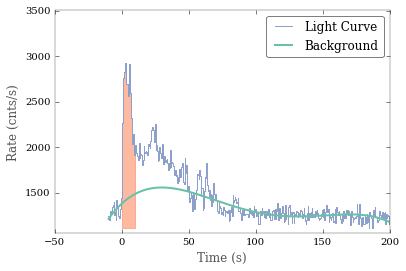

In [5]:
nai3.view_lightcurve(-10,200.,.5)

Oy! That is not so nice! Luckily, we can simply select another interval!


Looking for optimal polynomial grade:

delta log-likelihoods:
0 -> 1: delta Log-likelihood = 23.3146809903
1 -> 2: delta Log-likelihood = 3.33633299475
2 -> 3: delta Log-likelihood = 0.0565574553329
3 -> 4: delta Log-likelihood = 0.780464825686



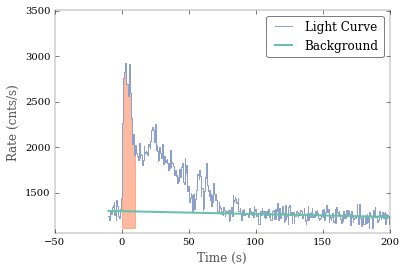

In [6]:
nai3.set_background_interval("-10.-0.","120-200") # You can select as many as required!
nai3.view_lightcurve(-10,200.,.5)

Ok! This is a much better fit. If we change our source interval the counts are automatically recalculated.
### Energy selection

We need to select the energies we would like to fit over. GBM has over/underflow channels which must be exlcuded from the fit. This is not always at the same energy, so we need to check.
**FermiGBM_TTE_Like**  (and **FermiGBMLike** ) allow you to plot the count spectra so you can see what you will be excluding in the fit.

Now using 115 channels out of 128


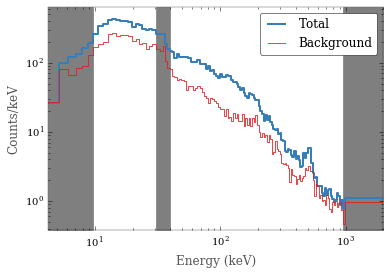

In [5]:
nai3.set_active_measurements("10.0-30.0", "40.0-950.0")
nai3.view_count_spectrum()

Now using 126 channels out of 128


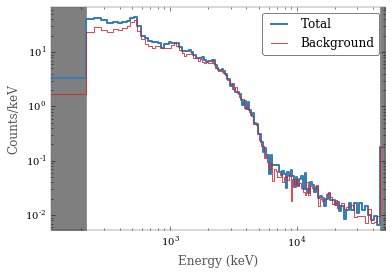

In [6]:
bgo0.set_active_measurements("250-43000")
bgo0.view_count_spectrum()

## Fitting!

We are now ready for the standard **3ML** process:


In [9]:
triggerName = 'bn080916009'
ra = 121.8
dec = -61.3


data_list = DataList(nai3,bgo0 )

band = Band()


GRB = PointSource( triggerName, ra, dec, spectral_shape=band )

model = Model( GRB )

model.display()

name,value,min_value,max_value,unit,delta,free
bn080916009.spectrum.main.Band.K,0.0001,None,None,1 / (cm2 keV s),1e-05,True
bn080916009.spectrum.main.Band.alpha,-1.0,-1.5,3.0,,0.1,True
bn080916009.spectrum.main.Band.xp,500.0,10.0,None,keV,50.0,True
bn080916009.spectrum.main.Band.beta,-2.0,-5.0,-1.6,,0.2,True


In [22]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,bn080916009.spectrum.main.Band.K,0.0298 +/- 0.0012,1 / (cm2 keV s)
1,bn080916009.spectrum.main.Band.alpha,-0.977 +/- 0.035,
2,bn080916009.spectrum.main.Band.xp,(8.4 +/- 1.3)e+02,keV
3,bn080916009.spectrum.main.Band.beta,-2.17 +/- 0.12,



NOTE: errors on parameters are approximate. Use get_errors().

Nuisance parameters:



Name,Value,Unit
InterCalib_of_NAI3,1,
InterCalib_of_BGO0,1,



Correlation matrix:



1.00,0.83,-0.94,0.57
0.83,1.00,-0.87,0.50
-0.94,-0.87,1.00,-0.67
0.57,0.50,-0.67,1.00



Values of -log(likelihood) at the minimum:



,instrument,-log(likelihood)
0,all,1637.501884
1,NAI3,782.590608
2,BGO0,854.911276


In [21]:
res = jl.get_errors()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,0.0298 -0.0013 +0.0015,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.98 -0.04 +0.04,
bn080916009.spectrum.main.Band.xp,(8.4 -1.3 +1.6)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.17 -0.16 +0.11,


 [*********************100%***********************]  completed in 0.3 s

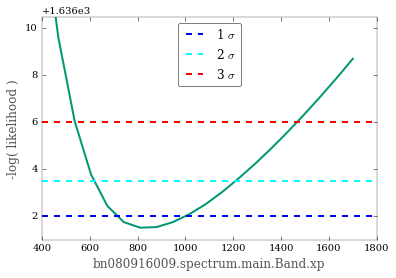

In [13]:
res = jl.get_contours(band.xp,400,1700,20)

 [*********************100%***********************]  completed in 8.0 s

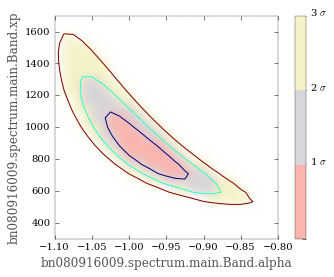

In [14]:
res = jl.get_contours(band.xp,300,1700,25,band.alpha,-1.1,-0.8,25)

## And if you really want to be sure => Go Bayesian!

In [23]:
# First define priors
# We can do it explicitly like this:
# (be careful not to choose the boundaries outside of the allowed value
# for the parameter, according to the min_value and max_value properties)

band.K.prior = Log_uniform_prior(lower_bound=1e-4, upper_bound=1)
band.xp.prior = Log_uniform_prior(lower_bound=10, upper_bound=1e5)

# or use the set_uninformative_prior method, which will use as lower_bound
# and upper_bound the current boundaries for the parameter. Such boundaries
# must exists and be finite

band.alpha.set_uninformative_prior(Uniform_prior)
band.beta.set_uninformative_prior(Uniform_prior)

bayes = BayesianAnalysis(model, data_list)

### Sample with Affine Invariant Sampling

In [24]:
samples = bayes.sample(n_walkers=50,burn_in=200, n_samples=1000)

Running burn-in of 200 samples...

 [*********************100%***********************]  completed in 9.4 s

Sampling...

 [**********************99%***********************]  992 / 1000 in 48.4 s (0:00:00 remaining)
Mean acceptance fraction: 0.56404


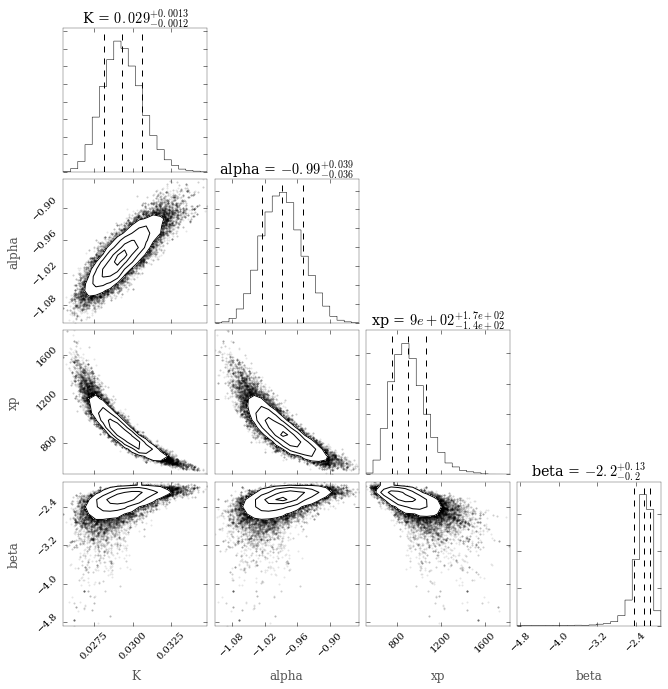

In [25]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)

### Sample with Nested Sampling (MULTINEST)

(see parallel demo for tips on parallel sampling with MPI)

In [26]:
samples = bayes.sample_multinest(n_live_points=400,resume=False)


Sampling...

MULTINEST has its own convergence criteria... you will have to wait blindly for it to finish
If INS is enabled, one can monitor the likelihood in the terminal for completion information
  analysing data from chains/fit-.txt


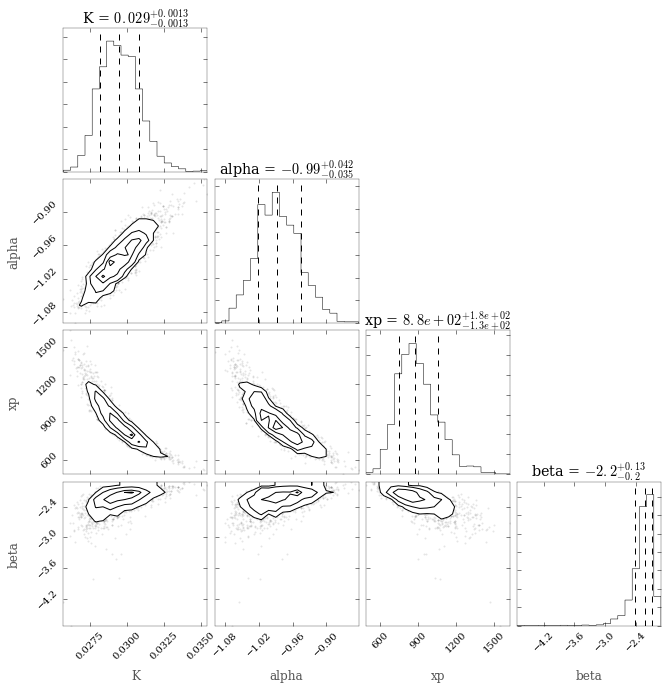

In [27]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)

#### Credible Regions

In [28]:
# equal-tailed credible regions
eq_tail = bayes.get_credible_intervals()


Name,Value,Unit
bn080916009.spectrum.main.Band.K,0.0295 -0.0006 +0.0007,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.987 -0.018 +0.020,
bn080916009.spectrum.main.Band.xp,(8.8 -0.7 +0.7)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.23 -0.08 +0.07,



(probability 68)


In [29]:
# highest denisty intervals
hdi = bayes.get_highest_density_interval()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,0.0295 -0.0025 +0.0026,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.99 -0.07 +0.08,
bn080916009.spectrum.main.Band.xp,(8.8 -2.7 +3.3)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.2 -0.4 +0.26,


#### Effective free parameters (experimental)

Determine the complexity of your model and data 


In [30]:
bayes.get_effective_free_parameters()

4.2874807768384926

# TODO

* Export TTE selections to PHA files for XSPEC
* Handling RSP2 files correctly
* Your suggestions!